# Deep Kernel Learning with Flux

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/AbstractGPs.jl/blob/master/examples/deep-kernel-learning/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/deep-kernel-learning/).*

## Package loading
We use a couple of useful packages to plot and optimize
the different hyper-parameters

In [1]:
using KernelFunctions
using Flux
using Distributions, LinearAlgebra
using Plots
using ProgressMeter
using AbstractGPs
default(; legendfontsize=15.0, linewidth=3.0);

## Data creation
We create a simple 1D Problem with very different variations

In [2]:
xmin = -3;
xmax = 3; # Limits
N = 150
noise = 0.01
x_train = collect(eachrow(rand(Uniform(xmin, xmax), N))) # Training dataset
target_f(x) = sinc(abs(x)^abs(x)) # We use sinc with a highly varying value
target_f(x::AbstractArray) = target_f(first(x))
y_train = target_f.(x_train) + randn(N) * noise
x_test = collect(eachrow(range(xmin, xmax; length=200))) # Testing dataset

200-element Vector{SubArray{Float64, 1, Base.ReshapedArray{Float64, 2, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Tuple{}}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}:
 [-3.0]
 [-2.969849246231156]
 [-2.9396984924623117]
 [-2.909547738693467]
 [-2.879396984924623]
 [-2.849246231155779]
 [-2.819095477386935]
 [-2.7889447236180906]
 [-2.758793969849246]
 [-2.728643216080402]
 ⋮
 [2.758793969849246]
 [2.7889447236180906]
 [2.819095477386935]
 [2.849246231155779]
 [2.879396984924623]
 [2.909547738693467]
 [2.9396984924623117]
 [2.969849246231156]
 [3.0]

## Model definition
We create a neural net with 2 layers and 10 units each
The data is passed through the NN before being used in the kernel

In [3]:
neuralnet = Chain(Dense(1, 20), Dense(20, 30), Dense(30, 5))

Chain(
  Dense(1, 20),                         # 40 parameters
  Dense(20, 30),                        # 630 parameters
  Dense(30, 5),                         # 155 parameters
)                   # Total: 6 arrays, 825 parameters, 3.598 KiB.

We use two cases :
- The Squared Exponential Kernel

In [4]:
k = SqExponentialKernel() ∘ FunctionTransform(neuralnet)

Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Function Transform: Chain(Dense(1, 20), Dense(20, 30), Dense(30, 5))

We use AbstractGPs.jl to define our model

In [5]:
gpprior = GP(k) # GP Prior
fx = AbstractGPs.FiniteGP(gpprior, x_train, noise) # Prior on f
fp = posterior(fx, y_train) # Posterior of f

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.FunctionTransform{Flux.Chain{Tuple{Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, Vector{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}, Vector{Float64}}}}(AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.FunctionTransform{Flux.Chain{Tuple{Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dense{typeof(identity), Matrix{Float32}, Vector{F

This compute the log evidence of `y`,
which is going to be used as the objective

In [6]:
loss(y) = -logpdf(fx, y)

@info "Init Loss = $(loss(y_train))"

[ Info: Init Loss = -117.2131227651419


Flux will automatically extract all the parameters of the kernel

In [7]:
ps = Flux.params(k)

Params([Float32[-0.11997254; -0.06321328; … ; 0.42709398; -0.29094;;], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.20493048 -0.25297317 … 0.1563551 0.23608945; 0.1769852 -0.33713102 … -0.21916316 -0.20467532; … ; -0.05103299 -0.18614005 … -0.06131267 0.31684428; -0.3441274 0.25702104 … 0.046566077 -0.109823555], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.017047925 0.24733686 … -0.17015083 -0.018232107; -0.34305382 -0.33940443 … 0.2874504 0.15815799; … ; -0.1822866 -0.21495293 … -0.24919048 -0.16924833; -0.23412968 0.25961345 … 0.19866431 -0.18350346], Float32[0.0, 0.0, 0.0, 0.0, 0.0]])

We show the initial prediction with the untrained model

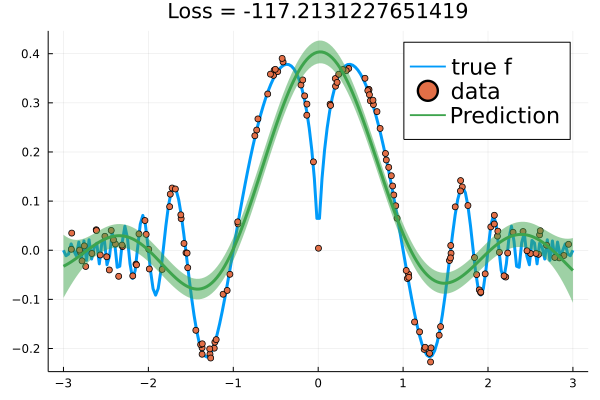

In [8]:
p_init = Plots.plot(
    vcat(x_test...), target_f; lab="true f", title="Loss = $(loss(y_train))"
)
Plots.scatter!(vcat(x_train...), y_train; lab="data")
pred = marginals(fp(x_test))
Plots.plot!(vcat(x_test...), mean.(pred); ribbon=std.(pred), lab="Prediction")

## Training

┌ Warning: Assignment to `pred` in soft scope is ambiguous because a global variable by the same name exists: `pred` will be treated as a new local. Disambiguate by using `local pred` to suppress this warning or `global pred` to assign to the existing global variable.
└ @ string:16
Progress:  10%|████                                     |  ETA: 0:01:11[ Info: 100/1000; loss = -147.73705688896035
Progress:  20%|████████▏                                |  ETA: 0:01:01[ Info: 200/1000; loss = -147.73712176671359
Progress:  30%|████████████▎                            |  ETA: 0:00:53[ Info: 300/1000; loss = -147.73712185884426
Progress:  40%|████████████████▍                        |  ETA: 0:00:43[ Info: 400/1000; loss = -147.73712185885765
Progress:  50%|████████████████████▌                    |  ETA: 0:00:34[ Info: 500/1000; loss = -147.73712185885807
Progress:  60%|████████████████████████▌                |  ETA: 0:00:27[ Info: 600/1000; loss = -147.73712185885748
Progress:  70%|██████

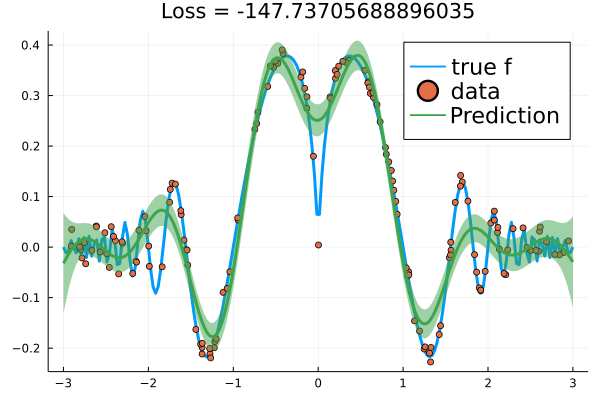

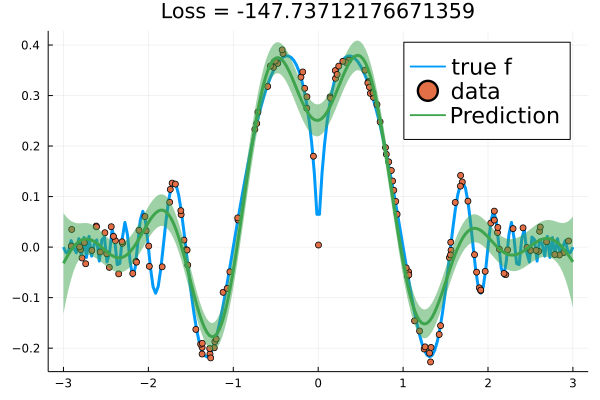

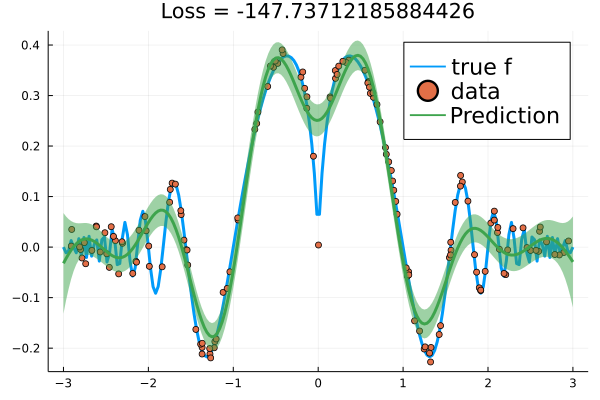

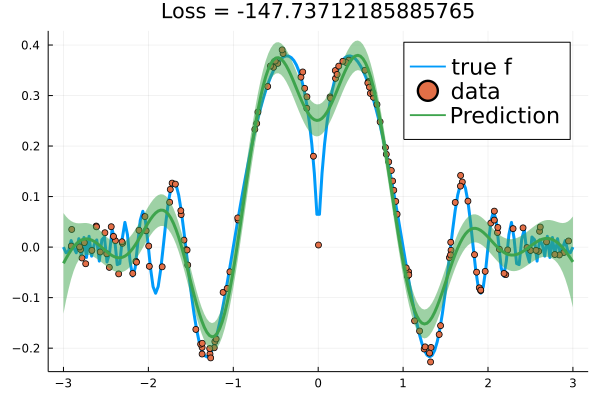

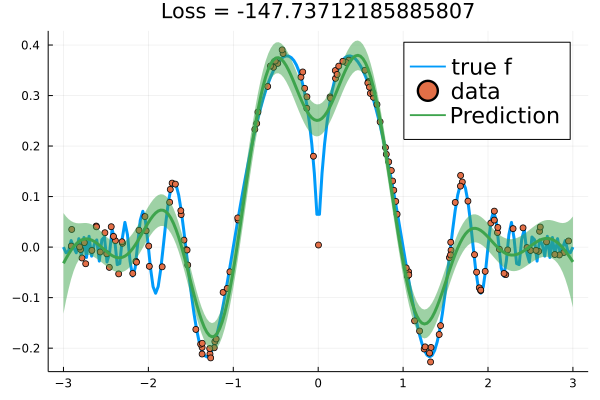

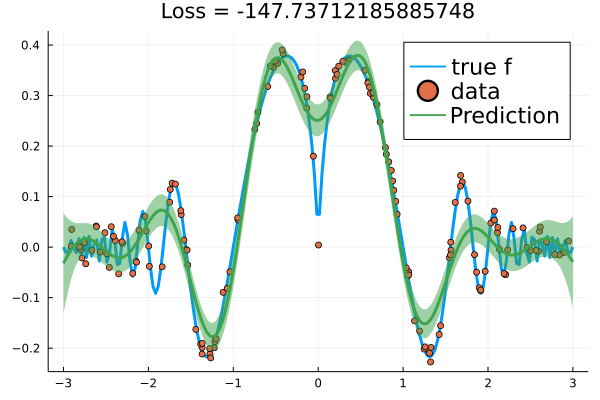

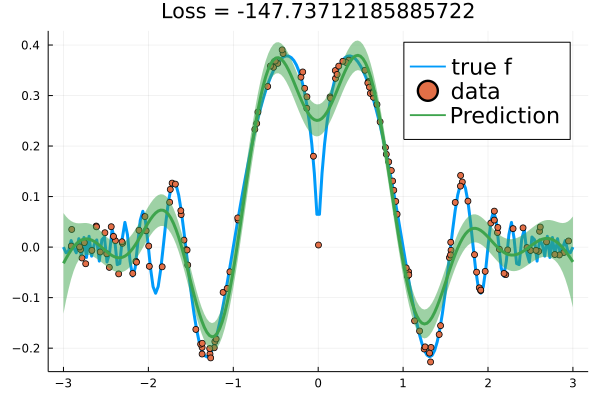

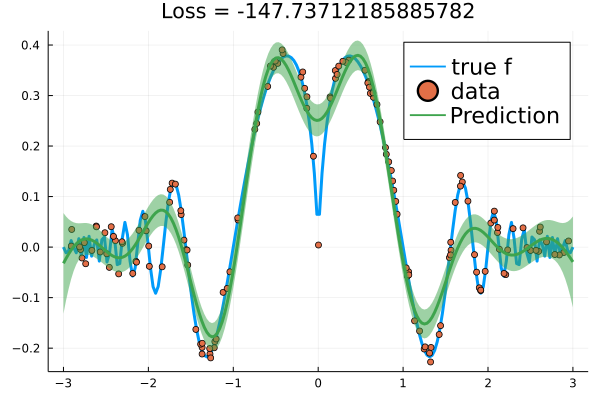

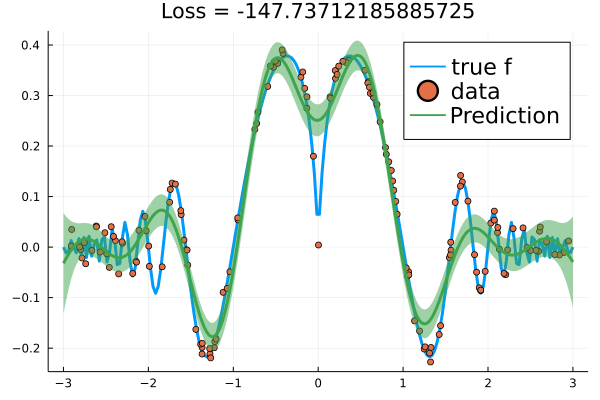

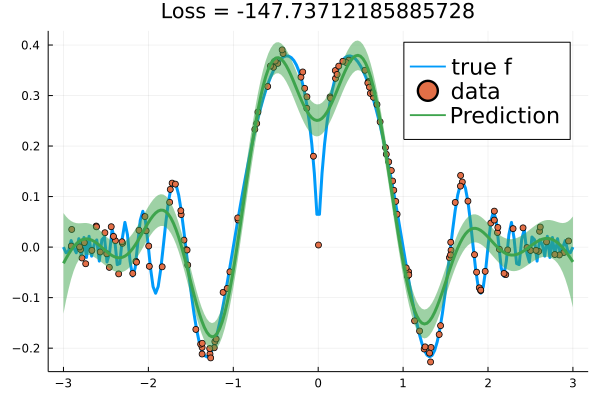

Plots.AnimatedGif("/tmp/jl_kGW3in.gif")
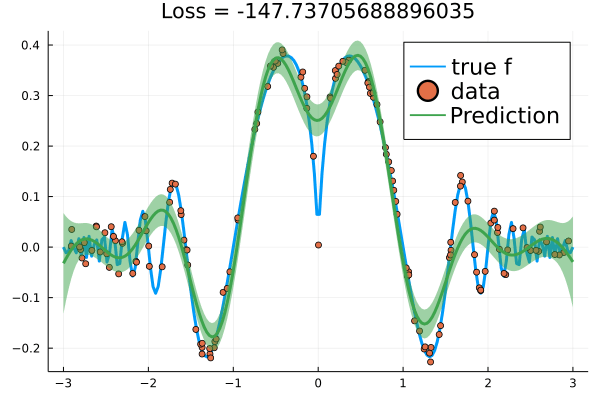

In [9]:
anim = Animation()
nmax = 1000
opt = Flux.ADAM(0.1)
@showprogress for i in 1:nmax
    global grads = gradient(ps) do
        loss(y_train)
    end
    Flux.Optimise.update!(opt, ps, grads)
    if i % 100 == 0
        L = loss(y_train)
        @info "$i/$nmax; loss = $L"
        p = Plots.plot(
            vcat(x_test...), target_f; lab="true f", title="Loss = $(loss(y_train))"
        )
        p = Plots.scatter!(vcat(x_train...), y_train; lab="data")
        pred = marginals(posterior(fx, y_train)(x_test))
        Plots.plot!(vcat(x_test...), mean.(pred); ribbon=std.(pred), lab="Prediction")
        frame(anim)
        display(p)
    end
end
gif(anim; fps=5)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*